# SYDE 556/750: Simulating Neurobiological Systems

Accompanying Readings: Chapter 8

## Dynamics

- Everything we've looked at so far has been feedforward
    - There's some pattern of activity in one group of neurons representing $x$
    - We want that to cause some pattern of activity in another group of neurons to represent $y=f(x)$
    - These can be chained together to make more complex systems $z=h(f(x)+g(y))$
- What about recurrent networks?
    - What happens when we connect a neural group back to itself?
    
<img src="files/lecture5/recnet1.png">



### Recurrent functions

- What if we do exactly what we've done so far in the past, but instead of connecting one group of neurons to another, we just connect it back to itself
    - Instead of $y=f(x)$
    - We get $x=f(x)$ (???)
- As written, this is clearly non-sensical
    - For example, if we do $f(x)=x+1$ then we'd have $x=x+1$, or $x-x=1$, or $0=1$

- But don't forget about time
    - What if it was $x_{t+1} = f(x_t)$
    - Which makes more sense because we're talking about a real physical system
    - This is a lot like a differential equation
    - What would happen if we built this?

### Try it out

- Let's try implementing this kind of circuit
- Start with $x_{t+1}=x_t+1$    

In [29]:
%pylab inline

`%matplotlib` prevents importing * from pylab and numpy


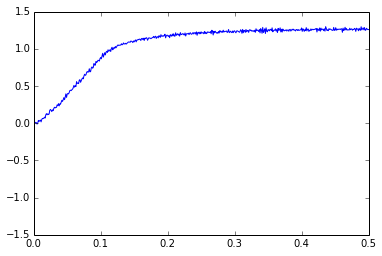

In [12]:
import nengo

model = nengo.Network()

with model:
    ensA = nengo.Ensemble(100, dimensions=1)
    
    def feedback(x):
        return x+1
    
    conn = nengo.Connection(ensA, ensA, function=feedback, synapse = 0.1)

    ensA_p = nengo.Probe(ensA, synapse=.01)
    
sim = nengo.Simulator(model)
sim.run(.5)

plot(sim.trange(), sim.data[ensA_p])
ylim(-1.5,1.5);

- That sort of makes sense
    - $x$ increases quickly, then hits an upper bound
- How quickly?
    - What parameters of the system affect this?
- What are the precise dynamics?

- What about $f(x)=-x$?

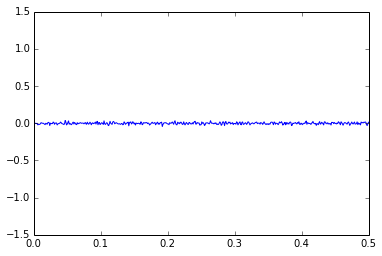

In [13]:
with model:
    def feedback(x):
        return -x
    
    conn.function = feedback

sim = nengo.Simulator(model)
sim.run(.5)

plot(sim.trange(), sim.data[ensA_p])
ylim(-1.5,1.5);

- That also makes sense.  What if we nudge it away from zero?

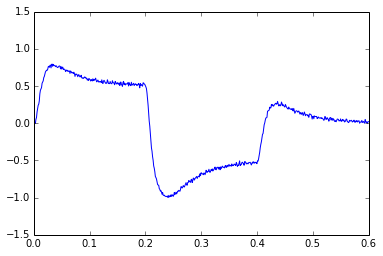

In [14]:
from nengo.utils.functions import piecewise

with model:
    stim = nengo.Node(piecewise({0:1, .2:-1, .4:0}))
    nengo.Connection(stim, ensA)
    
sim = nengo.Simulator(model)
sim.run(.6)

plot(sim.trange(), sim.data[ensA_p])
ylim(-1.5,1.5);

- With an input of 1, $x=0.5$
- With an input of -1, $x=-0.5$
- With an input of 0, it goes back to $x=0$
- Does this make sense?
    - Why / why not?
    - And why that particular timing/curvature?
    
- What about $f(x)=x^2$?    

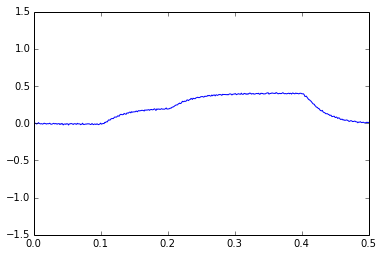

In [27]:
with model:
    stim.output = piecewise({.1:.2, .2:.4, .4:0})
    def feedback(x):
        return x*x
    
    conn.function = feedback

sim = nengo.Simulator(model)
sim.run(.5)

plot(sim.trange(), sim.data[ensA_p])
ylim(-1.5,1.5);    

- Well that's weird
    - Stable at $x=0$ with no input 
    - Stable at .2 
    - Unstable at .4, shoots up high
    - Something very strange happens around $x=1$ when the input is turned off
- Why is this happening?


### Making sense of dynamics

- Let's go back to something simple
- Just a single feed-forward neural population
    - Encode $x$ into current, compute spikes, decode filtered spikes into $\hat{x}$
- Instead of a constant input, let's change the input
    - Change it suddenly from zero to one to get a sense of what's happening with changes

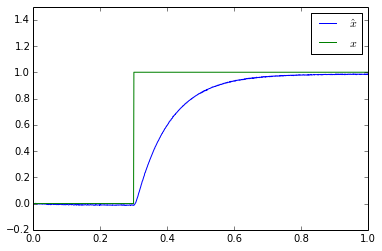

In [21]:
import nengo
from nengo.utils.functions import piecewise

model = nengo.Network(seed=4)

with model:
    stim = nengo.Node(piecewise({.3:1}))
    ensA = nengo.Ensemble(100, dimensions=1)
    
    def feedback(x):
        return x
    
    nengo.Connection(stim, ensA)
    #conn = nengo.Connection(ensA, ensA, function=feedback)

    stim_p = nengo.Probe(stim)
    ensA_p = nengo.Probe(ensA, synapse=.1)
    
sim = nengo.Simulator(model)
sim.run(1)

plot(sim.trange(), sim.data[ensA_p], label="$\hat{x}$")
plot(sim.trange(), sim.data[stim_p], label="$x$")
legend()
ylim(-.2,1.5);

- This was supposed to compute $f(x)=x$
- For a constant input, that works
    - But we get something else when there's a change in the input
- What is this difference?
    - What affects it?

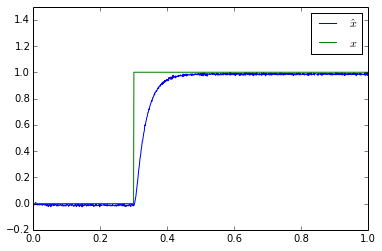

In [22]:
with model:
    ensA_p = nengo.Probe(ensA, synapse=.03)

sim = nengo.Simulator(model)
sim.run(1)

plot(sim.trange(), sim.data[ensA_p], label="$\hat{x}$")
plot(sim.trange(), sim.data[stim_p], label="$x$")
legend()
ylim(-.2,1.5);

- The time constant of the post-synaptic filter
- We're not getting $f(x)=x$
- Instead we're getting $f(x(t))=x(t)*h(t)$


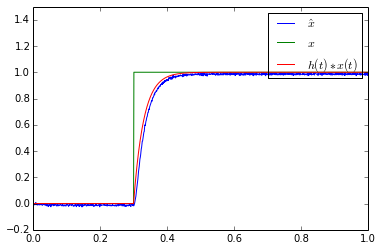

In [25]:
tau = 0.03
with model:
    ensA_p = nengo.Probe(ensA, synapse=tau)

sim = nengo.Simulator(model)
sim.run(1)

stim_filt = nengo.synapses.filt(sim.data[stim_p], synapse=tau, dt=sim.dt)

plot(sim.trange(), sim.data[ensA_p], label="$\hat{x}$")
plot(sim.trange(), sim.data[stim_p], label="$x$")
plot(sim.trange(), stim_filt, label="$h(t)*x(t)$")
legend()
ylim(-.2,1.5);

- So there are dynamics and filtering going on, since there is always a synaptic filter on a connection
- Recurrent connections are dynamic as well (i.e. passing past information to future state of the population)
- Let's take a look more carefully

### Recurrent connections

- So a connection actually approximates $f(x(t))*h(t)$
- So what does a recurrent connection do?

    - Also $x(t) = f(x(t))*h(t)$

- where $$
h(t) = \begin{cases}
    e^{-t/\tau} &\mbox{if } t > 0 \\ 
    0 &\mbox{otherwise} 
    \end{cases}
$$

- How can we work with this?

- General rule of thumb: convolutions are annoying, so let's get rid of them
- We could do a Fourier transform
   - $X(\omega)=F(\omega)H(\omega)$
   - But, since we are studying the response of a system (rather than a continuous signal), there's a more general and appropriate transform that makes life even easier:
- Laplace transform (it is more general because $s = a + j\omega$)
- The Laplace transform of our equations are:
   - $X(s)=F(s)H(s)$
   - $H(s)={1 \over {1+s\tau}}$
- Rearranging:

$X(s)=F(s){1 \over {1+s\tau}}$

$X(s)(1+s\tau) = F(s)$

$X(s) + X(s)s\tau = F(s)$

$sX(s) = {1 \over \tau} (F(s)-X(s))$

- Convert back into the time domain (inverse Laplace):

${dx \over dt} = {1 \over \tau} (f(x(t))-x(t))$





### Dynamics

- This says that if we introduce a recurrent connection, we end up implementing a differential equation

- So what happened with $f(x)=x+1$?
    - $\dot{x} = {1 \over \tau} (x+1-x)$
    - $\dot{x} = {1 \over \tau}$
- What about $f(x)=-x$?
    - $\dot{x} = {1 \over \tau} (-x-x)$
    - $\dot{x} = {-2x \over \tau}$
- And $f(x)=x^2$?    
    - $\dot{x} = {1 \over \tau} (x^2-x)$

- What if there's some differential equation we really want to implement?
    - We want $\dot{x} = f(x)$
    - So we do a recurrent connection of $f'(x)=\tau f(x)+x$
    - The resulting model will end up implementing $\dot{x} = {1 \over \tau} (\tau f(x)+x-x)=f(x)$
        

### Inputs

- What happens if there's an input as well?
    - We'll call the input $u$ from another population, and it is also computing some function $g(u)$
    - $x(t) = f(x(t))*h(t)+g(u(t))*h(t)$

- Follow the same derivation steps
    - $\dot{x} = {1 \over \tau} (f(x)-x + g(u))$

- So if you have some input that you want added to $\dot{x}$, you need to scale it by $\tau$

- This lets us do any differential equation of the form $\dot{x}=f(x)+g(u)$
    

### A derivation

#### Linear systems
- The book shows that we can implement any equation of the form

$\dot{x}(t) = A x(t) + B u(t)$

- Where $A$ and $x$ are a matrix and vector -- giving a standard control theoretic structure
<img src="files/lecture5/control_sys.png" width="400">
- Our goal is to convert this to a structure which has $h(t)$ as the transfer function instead of the standard $\int$
<img src="files/lecture5/control_sysh.png" width="400">

- Using Laplace on the standard form gives:

$sX(s) = A X(s) + B U(s)$

- Laplace on the 'neural control' form gives (as before where $F(s) = A'X(s) + B'U(s)$):

$X(s) = {1 \over {1 + s\tau}} (A'X(s) + B'U(s))$

$X(s) + \tau sX(s) = (A'X(s) + B'U(s))$

$sX(s) = {1 \over \tau} (A'X(s) + B'U(s) - X(s))$

$sX(s) = {1 \over \tau} ((A' - 1) X(s) + B'U(s))$

- Making the 'standard' and 'neural' equations equal to one another, we find that for any system with a given A and B, the A' and B' of the equivalent neural system are given by:

$A' = \tau A + I$ and

$B' = \tau B$

- where $I$ is the identity matrix

- This is nice because lots of engineers think of the systems they build in these terms (i.e. as linear control systems).

####Nonlinear systems
- In fact, these same steps can be taken to account for nonlinear control systems as well:

$\dot{x}(t) = F(x(t),u(t),t)$

- For a neural system with transfer function $h(t)$:

$X(s) = H(s)F'(X(s),U(s),s)$

$X(s) = {1 \over {1 + s\tau}} F'(X(s),U(s),s)$

$sX(s) = {1 \over \tau} (F'(X(s),U(s),s) - X(s))$

- This gives the general result (slightly more general than what we saw earlier):

$F'(X(s),U(s),s) = \tau(F(X(s),U(s),s)) + X(s)$

## Applications

### Eye control

- Part of the brainstem called the nuclei prepositus hypoglossi
- Input is eye velocity $v$
- Output is eye position $x$
- $\dot{x}=v$
    - This is an integrator ($x$ is the integral of $v$)

- It's a linear system, so, to get it in the standard control form $\dot{x}=Ax+Bu$ we have:
    - $A=0$
    - $B=1$
- So that means we need $A'=\tau 0 + I = 1$ and $B'=\tau 1 = \tau$
<img src="files/lecture5/eye_sys.png">


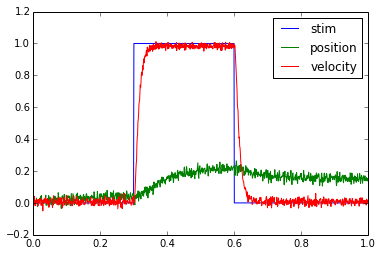

In [58]:
import nengo
from nengo.utils.functions import piecewise

tau = 0.01

model = nengo.Network('Eye control', seed=4)

with model:
    stim = nengo.Node(piecewise({.3:1, .6:0 }))
    velocity = nengo.Ensemble(100, dimensions=1)
    position = nengo.Ensemble(100, dimensions=1)
    
    def feedback(x):
        return 1*x
    
    conn = nengo.Connection(stim, velocity)
    conn = nengo.Connection(velocity, position, transform=tau, synapse=tau)
    conn = nengo.Connection(position, position, function=feedback, synapse=tau)

    stim_p = nengo.Probe(stim)
    position_p = nengo.Probe(position, synapse=.01)
    velocity_p = nengo.Probe(velocity, synapse=.01)
    
sim = nengo.Simulator(model)
sim.run(1)

plot(sim.trange(), sim.data[stim_p], label = "stim")
plot(sim.trange(), sim.data[position_p], label = "position")
plot(sim.trange(), sim.data[velocity_p], label = "velocity")
legend(loc="best");

- That's pretty good... the area under the input is about equal to the magnitude of the output.
- But, in order to be a perfect integrator, we'd need exactly $x=1\times x$
    - We won't get exactly that
    - Neural implementations are always approximations
- Two forms of error:
    - $E_{distortion}$, the decoding error
    - $E_{noise}$, the random noise error
- What will they do?
### Distortion error
<img src="files/lecture5/integrator_error.png">

- What affects this?
    


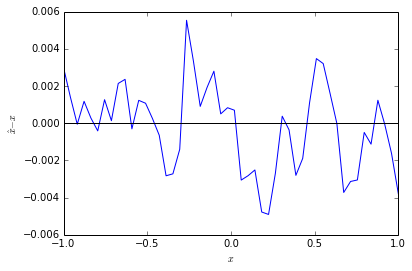

In [19]:
import nengo
from nengo.dists import Uniform
from nengo.utils.ensemble import tuning_curves

model = nengo.Network(label='Neurons')
with model:
    neurons = nengo.Ensemble(200, dimensions=1, max_rates=Uniform(100,200))

    connection = nengo.Connection(neurons, neurons)
    
sim = nengo.Simulator(model)

d = sim.data[connection].weights.T

x, A = tuning_curves(neurons, sim)

xhat = numpy.dot(A, d)

plot(x, xhat-x)
axhline(0, color='k')
xlabel('$x$')
ylabel('$\hat{x}-x$');

- So we can think of the distortion error as introducing a bunch of local attractors into the representation
    - Any 'downward' x-crossing will be a stable point ('upwards' is unstable).
    - There will be a tendency to drift towards one of these even if the input is zero.

### Noise error
- What will random noise do?
    - Push the representation back and forth
    - What if it is small?
    - What if it is large?
- What will changing the post-synaptic time constant $\tau$ do?
    - How does that interact with noise?

- But real eyes aren't perfect integrators
    - If you get someone to look at someting, then turn off the lights but tell them to keep looking in the same direction, their eye will drift back to centre
    - How do we implement that?
    
$\dot{x}=-{1 \over \tau_c}x + v$

- $\tau_c$ is the time constant of that return to centre
    
- $A'=\tau {-1 \over \tau_c}+1$
- $B' = \tau$

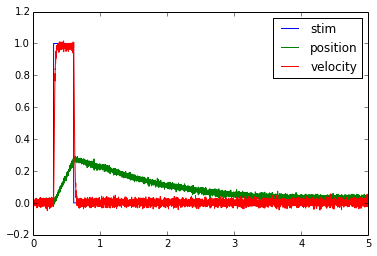

In [66]:
import nengo
from nengo.utils.functions import piecewise

tau = 0.1
tau_c = 2.0

model = nengo.Network('Eye control', seed=5)

with model:
    stim = nengo.Node(piecewise({.3:1, .6:0 }))
    velocity = nengo.Ensemble(100, dimensions=1)
    position = nengo.Ensemble(200, dimensions=1)
    
    def feedback(x):
        return (-tau/tau_c + 1)*x
    
    conn = nengo.Connection(stim, velocity)
    conn = nengo.Connection(velocity, position, transform=tau, synapse=tau)
    conn = nengo.Connection(position, position, function=feedback, synapse=tau)

    stim_p = nengo.Probe(stim)
    position_p = nengo.Probe(position, synapse=.01)
    velocity_p = nengo.Probe(velocity, synapse=.01)
    
sim = nengo.Simulator(model)
sim.run(5)

plot(sim.trange(), sim.data[stim_p], label = "stim")
plot(sim.trange(), sim.data[position_p], label = "position")
plot(sim.trange(), sim.data[velocity_p], label = "velocity")
legend(loc="best");

- That also looks right.  Note that as $\tau_c \rightarrow \infty$ this will approach the integrator.
- Humans (a) and Goldfish (b)
- Humans have more neurons doing this than goldfish (~1000 vs ~40)
- They also have slower decay (70 s vs. 10 s).
- Why do these fit together?

<img src="files/lecture5/integrator_decay.png">

### Controlled Integrator

- What if we want an integrator where we can adjust the decay on-the-fly?
- Separate input telling us what the decay constant $d$ should be

$\dot{x} = -d x + v$

- So there are two inputs: $v$ and $d$


- This is no longer in the standard $Ax + Bu$ form. Sort of...
    - Let $A = -d(t)$, so it's not a matrix
    - But it is of the more general form: ${dx \over dt}=f(x)+g(u)$
    
- We need to compute a nonlinear function of an input ($d$) and the state variable ($x$)
- How can we do this?
    - Going to 2D so we can compute the nonlinear function
    - Let's have the state variable be $[x, d]$
    
<img src="files/lecture5/controlled_integrator.png" width = 400>    

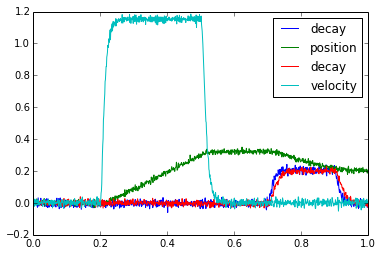

In [67]:
import nengo
from nengo.utils.functions import piecewise

tau = 0.1

model = nengo.Network('Controlled integrator', seed=1)

with model:
    vel = nengo.Node(piecewise({.2:1.5, .5:0 }))
    dec = nengo.Node(piecewise({.7:.2, .9:0 }))
    
    velocity = nengo.Ensemble(100, dimensions=1)
    decay = nengo.Ensemble(100, dimensions=1)
    position = nengo.Ensemble(400, dimensions=2)
    
    def feedback(x):
        return -x[1]*x[0]+x[0], 0
    
    conn = nengo.Connection(vel, velocity)
    conn = nengo.Connection(dec, decay)
    conn = nengo.Connection(velocity, position[0], transform=tau, synapse=tau)
    conn = nengo.Connection(decay, position[1], synapse=0.01)
    conn = nengo.Connection(position, position, function=feedback, synapse=tau)

    position_p = nengo.Probe(position, synapse=.01)
    velocity_p = nengo.Probe(velocity, synapse=.01)
    decay_p = nengo.Probe(decay, synapse=.01)
    
sim = nengo.Simulator(model)
sim.run(1)

plot(sim.trange(), sim.data[decay_p])
lineObjects = plot(sim.trange(), sim.data[position_p])
plot(sim.trange(), sim.data[velocity_p])
legend(('decay','position','decay','velocity'),loc="best");

In [68]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "controlled_integrator.py.cfg")

### Other fun functions

- Oscillator
    - $F = -kx = m \ddot{x}$ let $\omega = \sqrt{\frac{k}{m}}$
    - $\frac{d}{dt} \begin{bmatrix}
\omega x \\
\dot{x}
\end{bmatrix}
=
\begin{bmatrix}
0 & \omega \\
-\omega & 0
\end{bmatrix}$
    - $\dot{x}=[x_1, -x_0]$

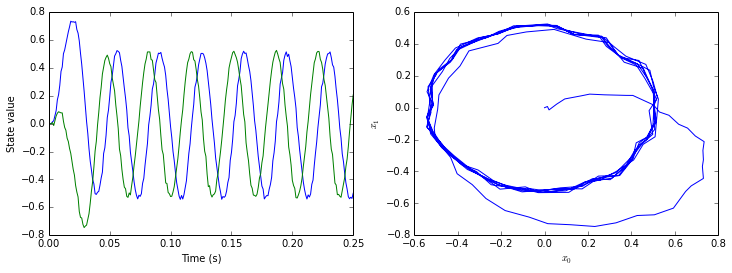

In [42]:
import nengo

model = nengo.Network('Oscillator')

freq = 8000

with model:
    stim = nengo.Node(lambda t: [.5,.5] if t<.02 else [0,0])
    
    osc = nengo.Ensemble(200, dimensions=2)
    
    def feedback(x):
        return x[0]+x[1], -x[0]+x[1]
    
    nengo.Connection(osc, osc, function=feedback)
    nengo.Connection(stim, osc)
    
    osc_p = nengo.Probe(osc, synapse=.01)
    
sim = nengo.Simulator(model)
sim.run(.25)

figure(figsize=(12,4))
subplot(1,2,1)
plot(sim.trange(), sim.data[osc_p]);
xlabel('Time (s)')
ylabel('State value')
       
subplot(1,2,2)
plot(sim.data[osc_p][:,0],sim.data[osc_p][:,1])
xlabel('$x_0$')
ylabel('$x_1$');

In [43]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "oscillator.py.cfg")

- Lorenz Attractor (a chaotic attractor)

    - $\dot{x}=[10x_1-10x_0, -x_0 x_2-x_1, x_0 x_1 - {8 \over 3}(x_2+28)-28]$


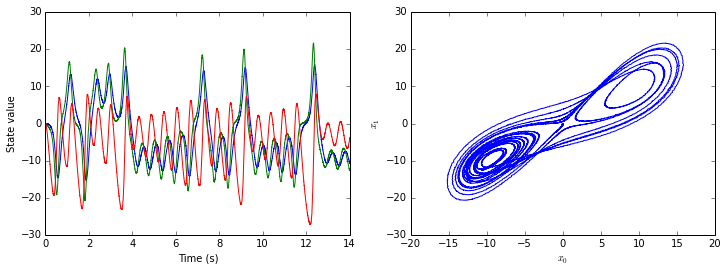

In [44]:
import nengo

model = nengo.Network('Lorenz Attractor', seed=3)

tau = 0.1
sigma = 10
beta = 8.0/3
rho = 28

def feedback(x):
    dx0 = -sigma * x[0] + sigma * x[1]
    dx1 = -x[0] * x[2] - x[1]
    dx2 = x[0] * x[1] - beta * (x[2] + rho) - rho
    return [dx0 * tau + x[0], 
            dx1 * tau + x[1], 
            dx2 * tau + x[2]]

with model:
    lorenz = nengo.Ensemble(2000, dimensions=3, radius=60)
    
    nengo.Connection(lorenz, lorenz, function=feedback, synapse=tau)
    
    lorenz_p = nengo.Probe(lorenz, synapse=tau)
    
sim = nengo.Simulator(model)
sim.run(14)

figure(figsize=(12,4))
subplot(1,2,1)
plot(sim.trange(), sim.data[lorenz_p]);
xlabel('Time (s)')
ylabel('State value')
       
subplot(1,2,2)
plot(sim.data[lorenz_p][:,0],sim.data[lorenz_p][:,1])
xlabel('$x_0$')
ylabel('$x_1$');

In [45]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "lorenz.py.cfg")

- Note: This is not the original Lorenz attractor.  
    - The original is $\dot{x}=[10x_1-10x_0, x_0 (28-x_2)-x_1, x_0 x_1 - {8 \over 3}(x_2)]$
    - Why change it to $\dot{x}=[10x_1-10x_0, -x_0 x_2-x_1, x_0 x_1 - {8 \over 3}(x_2+28)-28]$?
    - What's being changed here?

### Oscillators with different paths

- Since we can implement any function, we're not limited to linear oscillators
- What about a "square" oscillator?
    - Instead of the value going in a circle, it traces out a square

$$
{\dot{x}} = \begin{cases}
    [r, 0] &\mbox{if } |x_1|>|x_0| \wedge x_1>0 \\ 
    [-r, 0] &\mbox{if } |x_1|>|x_0| \wedge x_1<0 \\ 
    [0, -r] &\mbox{if } |x_1|<|x_0| \wedge x_0>0 \\ 
    [0, r] &\mbox{if } |x_1|<|x_0| \wedge x_0<0 \\ 
    \end{cases}
$$    

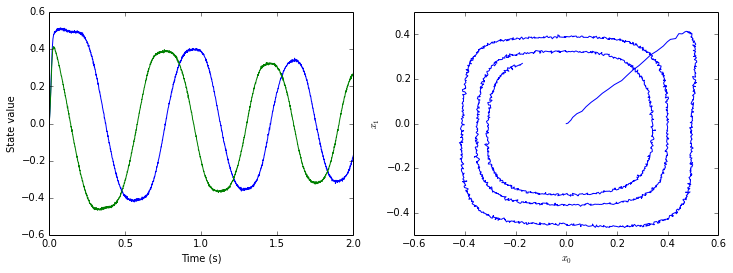

In [46]:
import nengo

model = nengo.Network('Square Oscillator')

tau = 0.02
r=4

def feedback(x):    
    if abs(x[1])>abs(x[0]):
        if x[1]>0: dx=[r, 0]
        else: dx=[-r, 0]
    else:
        if x[0]>0: dx=[0, -r]
        else: dx=[0, r]
    return [tau*dx[0]+x[0], tau*dx[1]+x[1]] 

with model:
    stim = nengo.Node(lambda t: [.5,.5] if t<.02 else [0,0])
    
    square_osc = nengo.Ensemble(1000, dimensions=2)
    
    nengo.Connection(square_osc, square_osc, function=feedback, synapse=tau)
    nengo.Connection(stim, square_osc)
    
    square_osc_p = nengo.Probe(square_osc, synapse=tau)
    
sim = nengo.Simulator(model)
sim.run(2)

figure(figsize=(12,4))
subplot(1,2,1)
plot(sim.trange(), sim.data[square_osc_p]);
xlabel('Time (s)')
ylabel('State value')
       
subplot(1,2,2)
plot(sim.data[square_osc_p][:,0],sim.data[square_osc_p][:,1])
xlabel('$x_0$')
ylabel('$x_1$');

- Does this do what you expect?
- How is it affected by:
    - Number of neurons?
    - Post-synaptic time constant?
    - Decoding filter time constant?
    - Speed of oscillation (``r``)?

- What about this shape?



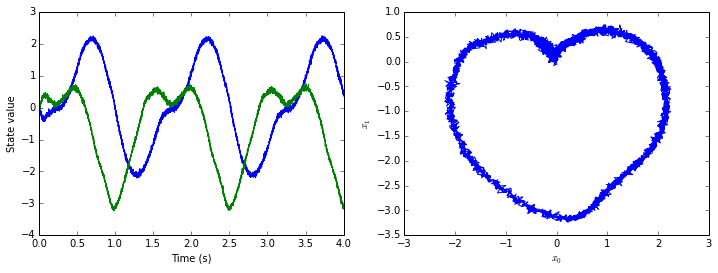

In [47]:
import nengo

model = nengo.Network('Heart Oscillator')

tau = 0.02
r=4

def feedback(x):    
    return [-tau*r*x[1]+x[0], tau*r*x[0]+x[1]]

def heart_shape(x):
    theta = np.arctan2(x[1], x[0])
    r = 2 - 2 * np.sin(theta) + np.sin(theta)*np.sqrt(np.abs(np.cos(theta)))/(np.sin(theta)+1.4)
    return -r*np.cos(theta), r*np.sin(theta)

with model:
    stim = nengo.Node(lambda t: [.5,.5] if t<.02 else [0,0])
    
    heart_osc = nengo.Ensemble(1000, dimensions=2)
    heart = nengo.Ensemble(100, dimensions=2, radius=4)
    
    nengo.Connection(stim, heart_osc)
    nengo.Connection(heart_osc, heart_osc, function=feedback, synapse=tau)
    nengo.Connection(heart_osc, heart, function=heart_shape, synapse=tau)
    
    heart_p = nengo.Probe(heart, synapse=tau)
    
sim = nengo.Simulator(model)
sim.run(4)

figure(figsize=(12,4))
subplot(1,2,1)
plot(sim.trange(), sim.data[heart_p]);
xlabel('Time (s)')
ylabel('State value')
       
subplot(1,2,2)
plot(sim.data[heart_p][:,0],sim.data[heart_p][:,1])
xlabel('$x_0$')
ylabel('$x_1$');

- We are doing things differently here
- The actual $x$ value is a normal circle oscillator
- The heart shape is a function of $x$
    - But that's just a different decoder
- Would it be possible to do an oscillator where $x$ followed this shape?
    - How could we tell them apart in terms of neural behaviour?


### Controlled Oscillator

- Change the frequency of the oscillator on-the-fly

- $\dot{x}=[x_1 x_2, -x_0 x_2]$

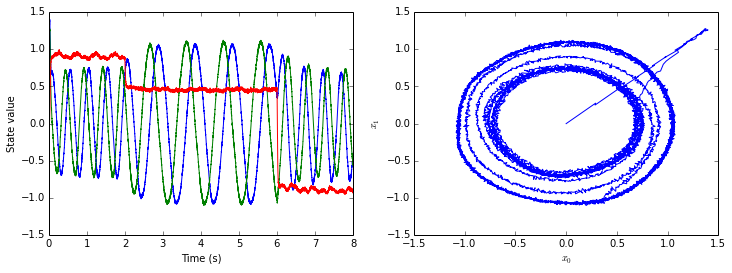

In [48]:
import nengo
from nengo.utils.functions import piecewise


model = nengo.Network('Controlled Oscillator')

tau = 0.1
scale=20

def feedback(x):
    return x[1]*x[2]*scale*tau+1.1*x[0], -x[0]*x[2]*scale*tau+1.1*x[1], 0

with model:
    stim = nengo.Node(lambda t: [20,20] if t<.02 else [0,0])
    freq = nengo.Node(piecewise({0:1, 2:.5, 6:-1}))
    
    ctrl_osc = nengo.Ensemble(500, dimensions=3)
    
    nengo.Connection(ctrl_osc, ctrl_osc, function=feedback, synapse=tau)
    nengo.Connection(stim, ctrl_osc[0:2])
    nengo.Connection(freq, ctrl_osc[2])
    
    ctrl_osc_p = nengo.Probe(ctrl_osc, synapse=0.01)
    
sim = nengo.Simulator(model)
sim.run(8)

figure(figsize=(12,4))
subplot(1,2,1)
plot(sim.trange(), sim.data[ctrl_osc_p]);
xlabel('Time (s)')
ylabel('State value')
       
subplot(1,2,2)
plot(sim.data[ctrl_osc_p][:,0],sim.data[ctrl_osc_p][:,1])
xlabel('$x_0$')
ylabel('$x_1$');

In [49]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "controlled_oscillator.py.cfg")